In [2]:
import json
import logging
import os
import sys
import urllib
import warnings
from datetime import datetime, date

import pandas as pd
from sqlalchemy import create_engine, text
import json 


### Prepare the data for Band Analysis (RedZoneV2-based vs. Anson's IBV Score-based)

#### Imoport the data with decoded model output JSON

In [4]:
# import the data and try to parse the JSON output
server = '192.168.1.15'
username = 'Junchen'
password = '9DFXjhhlR3k5'
database = 'BankuityPostOnboarding'

params = urllib.parse.quote_plus(
    "DRIVER={ODBC Driver 18 for SQL Server};"
    f"SERVER={server},1433;DATABASE={database};UID={username};PWD={password};"
    "Encrypt=yes;TrustServerCertificate=yes;"
)
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

cnxn = engine.connect()

query1 = f""" 
SELECT *,
          CONVERT(VARCHAR(MAX),
                  DECOMPRESS(ResponseJSON)
         ) AS ResponseJSONText
FROM BankuityPostOnboarding.dbo.SpeedyAnalysis
WHERE ExperimentName = 'loonie_rerun_V2';
"""

df_rerun = pd.read_sql(query1, cnxn)

In [5]:
print(df_rerun.shape)

(6897, 11)


#### Write the ResponseJSONText to Local (CAREFULL TO RUN!!!!!!!)


In [ ]:
""" output_dir = "/Users/starsrain/nov2025_concord/loonie_bankuity_rerun/rerun_output_JSONs_V2"
os.makedirs(output_dir, exist_ok=True)

for token, response_text in zip(df_rerun.IBVToken.values, df_rerun.ResponseJSONText.values):
    try:
        data = json.loads(response_text) if isinstance(response_text, str) else response_text
        filename = os.path.join(output_dir, f"ModelResponse_{token}.json")
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=4, separators=(',', ': '), ensure_ascii=False)
    except Exception as e:
        print(token, e) """

#### Extract the RedZoneV2 RiskScore from the JSONs

In [6]:
import re

input_dir = "/Users/starsrain/nov2025_concord/loonie_bankuity_rerun/rerun_output_JSONs_V2"
rows = []

for filename in os.listdir(input_dir):
    if not filename.endswith(".json"):
        continue
    match = re.search(r"_(\d+)\.json$", filename)
    if not match:
        continue
    ibv_status_id = int(match.group(1))
    file_path = os.path.join(input_dir, filename)
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            payload = json.load(f)
        customer = (payload or {}).get("customerInfo") or {}
        scores = customer.get("scores", {})
        redzone = scores.get("redZoneV2", {})
        model_score = redzone.get("modelScore")
        risk_score = None
        if isinstance(model_score, list) and model_score:
            first = model_score[0] if isinstance(model_score[0], dict) else None
            risk_score = first.get("riskScore") if first else None
        elif isinstance(model_score, dict):
            risk_score = model_score.get("riskScore")
        rows.append({"IBVStatusID": ibv_status_id, "redZoneV2_score": risk_score})
    except Exception as e:
        rows.append({"IBVStatusID": ibv_status_id, "redZoneV2_score": None})


df_redzone_scores = pd.DataFrame(rows).sort_values("IBVStatusID").reset_index(drop=True)

print(df_redzone_scores.head(10))
print(df_redzone_scores.shape)


   IBVStatusID  redZoneV2_score
0          757       145.000000
1         1258       162.000000
2         1382        78.979465
3         1810       298.000000
4         2334        94.987807
5         3158       224.000000
6         3509       216.000000
7         3513        61.982032
8         3586       154.000000
9         3854       146.000000
(6897, 2)


#### Get the metrics dataframe

In [7]:
from sqlalchemy import create_engine 
import urllib
server = '192.168.1.15'
username = 'Junchen'
password = '9DFXjhhlR3k5'
database = 'LF_LMSMaster'

params = urllib.parse.quote_plus(
    "DRIVER={ODBC Driver 18 for SQL Server};"
    f"SERVER={server},1433;DATABASE={database};UID={username};PWD={password};"
    "Encrypt=yes;TrustServerCertificate=yes;"
)
engine = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)


cnxn = engine.connect()
query1 = """ 
USE LF_LMSMASTER

drop table if EXISTS #t1
select ibvT.IBVStatusID, A.Application_ID, A.PortfolioID, A.CustomerID, A.ApplicationDate, CustEmail,
case when ApplicationSteps like '%S%' then 1 else 0 end as NewlyScored,
case when A.ApplicationStatus in ('A','P') then 1 else 0 end as Accepted,
case when A.ApplicationStatus in ('A','P') then A.LeadPurchasePrice else 0 end as LeadPurchasePrice,
case when L.LoanStatus not in ('V','W','G','K') and A.ApplicationStatus='J'  then 1 else 0 end as PartialPreApproved,
case when L.LoanStatus not in ('V','W','G','K')  then 1 else 0 end as Originated,
L.LoanID, datediff(year, VW.DOB, A.ApplicationDate) as Age,
case when VW.Frequency in ('B','S') then 'B' else VW.Frequency end as Frequency,
case when L.LoanStatus not in ('V','W','G','K') then L.OriginatedAmount else null end as OriginatedAmount,
LP.Provider_name, OriginationDate, LOANSTATUS,
case when ((L.RenewalLoanId <> '0') or (A.LPCampaign = 'RENEW'))  then 'RENEWAL' when ApplicationSteps not like '%R%' then 'NEW' else 'REPEAT' end as CustType, RenewalLoanId
into #t1
from Application A
left join Loans L on A.Application_ID = L.ApplicationID and A.PortFolioID = L.PortFolioID
left join LeadProvider LP on A.LeadProviderID = LP.LeadProviderID
left join LF_LMS_Logs..VW_ApplicationDump VW on A.APPGUID = VW.APPGUID
--left join [LF_BankData].[dbo].[IBVStatus] as ibvT on ibvT.AccountNumber = A.CustomerSSN
left join [LF_BankData].[dbo].[IBVStatus] as ibvT on ibvT.ApplicationID = A.Application_ID AND ibvT.PortfolioID= A.PortfolioID
where A.ApplicationDate>'2023-04-30' and ((CustEmail is null) or  (CustEmail not in ( 'josh@concordadvice.com', 'tiffany.speedyservicing@gmail.com','bobby@speedyservicing.com',
'and.kom@example.com', 'and.tor020@example.com', ' and.tor050@example.com', 'and.torrc4@example.com',
'test@dot818.com', 'test@example.com', 'test@gmail.com', 'test@loanscanada.ca', 'test@test.com', 'test2@test.com',
'testerqad@gmail.com', 'testik@test.com', 'testteam@dmaassociatescorp.com', 'tiffany.speedyservicing@gmail.com')))

UPDATE #t1 -- update the renewal loanid from 0 to correct previous loanIDs
SET #t1.RenewalLoanId = B.RenewalLoanId
from #t1 A inner join (select * from
(select A.LoanID, L.LoanID as RenewalLoanId, row_number() over (partition by A.LoanID order by datediff(day, L.OriginationDate, A.OriginationDate) desc) as RN from #t1 A
inner join Application A2 on A.CustomerID = A2.CustomerID and A2.ApplicationDate < A.ApplicationDate
inner join Loans L on A2.Application_ID = L.ApplicationID and A2.PortFolioID = L.PortFolioID and L.OriginationDate < A.OriginationDate and L.LoanStatus not in ('W','V','G','K')
where A.CustType = 'RENEWAL' and A.RenewalLoanId = '0') K where RN=1) B on A.LoanID = B.LoanID

-- Peak #t1 temp table
/* SELECT *
FROM #t1
WHERE IBVStatusID = 1810 */

drop table if EXISTs #t11
select A.Application_ID, A.PortFolioID, A.LoanID, rank() over(partition by A.CustomerID order by OriginationDate asc) as CustSSNLoanNum
into #t11
from #t1 A
where A.Originated=1

-- Peak #t11 temp table
/* SELECT *
FROM #t11 */
--WHERE IBVStatusID = 1810

-- scoring result for PlaidUDW_v1 and NegativeDBModelLP_v1
drop table if EXISTS #t2
select *
into #t2 from
(select A.*, B1.ExtResponse as B1ExtResponse, B2.ExtResponse as B2ExtResponse,
NDScore, IBVScore, NDBand,IBVBand,
row_number() over (partition by A.Application_ID, A.PortfolioID order by case when B2.ExtResponse is not null and B1.ExtResponse <> '' then 1 else 0 end desc,B.ApplicationDate desc) as RN
from #t1 A
left join Application B on A.CustomerID = B.CustomerID and A.ApplicationDate >= B.ApplicationDate and B.ApplicationSteps like '%S%'
left join ScoringPythonResult B1 CROSS APPLY OPENJSON(B1.ExtResponse) WITH (IBVScore int '$.ModelScore', IBVBand int '$.IBVBand')  on B.Application_ID = B1.ApplicationID and B.PortFolioID = B1.PortfolioID and B1.iLabel= 'IBVBand'
left join ScoringPythonResult B2 CROSS APPLY OPENJSON(B2.ExtResponse) WITH (NDScore int '$.ModelScore', NDBand int '$.NDBand') on B.Application_ID = B2.ApplicationID and B.PortFolioID = B2.PortfolioID and B2.iLabel= 'NDBand' ) K where RN=1
ALTER TABLE #t2
DROP COLUMN RN;
--peak #t2 table
/* SELECT TOP 10 *
FROM #t2
WHERE IBVStatusID IS NOT NULL */

/* ================================
   GET FPDFA new logic
   STEP 1: BASE TABLE – FIRST INSTALLMENTS ONLY
   ================================ */
DROP TABLE IF EXISTS #LF_LoanDefault;

SELECT  
      L.LoanID
    , L.ApplicationID AS Application_ID
    , A.APPGUID
    , A.ApplicationDate
    , A.ApplicationSteps
    , L.PortfolioID
    , L.LoanStatus
    , P.InstallmentNumber
    , P.PaymentStatus
    , P.PaymentType
    , P.PaymentMode
    , P.AttemptNo
    , P.TransactionDate
    , P.PaymentID
    , I.InstallmentID
    , I.iPaymentMode
    , I.DueDate
    , I.Status
    , CASE WHEN I.Status = 684 THEN 1 ELSE 0 END AS Pending    -- exclude pendings
INTO #LF_LoanDefault
FROM LF_LMSMaster..Loans L
LEFT JOIN LF_LMSMaster..Payment      P ON P.LoanID      = L.LoanID
LEFT JOIN LF_LMSMaster..Installments I ON I.InstallmentID = P.InstallmentID
LEFT JOIN LF_LMSMaster..Application  A 
       ON A.PortfolioID   = L.PortfolioID
      AND A.Application_ID = L.ApplicationID
WHERE A.ApplicationDate > '2023-04-30'
  AND I.InstallmentNumber = 1;


/* ================================
   STEP 2: FLAG FPDFA + FIRST LOAN INSTALLMENT
   ================================ */
DROP TABLE IF EXISTS #LoanDefault_Flag;

SELECT 
      L.*
      
    /* ---------- FPDFA FLAG ---------- */
    , CASE 
        WHEN L.PaymentStatus = 'R'
         AND L.PaymentType IN ('I','S','A')
         AND L.PaymentMode IN ('A','B','D')
         AND L.DueDate <= CAST(GETDATE() AS date)
         AND NOT EXISTS (
                SELECT 1
                FROM #LF_LoanDefault ld
                WHERE ld.InstallmentID = L.InstallmentID
                  AND ld.PaymentStatus = 'D'
                  AND ld.PaymentType NOT IN ('3','~','Q')
                  AND ld.PaymentMode IN ('A','D','B')
                  AND CONVERT(date, ld.TransactionDate) = CONVERT(date, L.DueDate)
             )
        THEN 1 ELSE 0 
      END AS FPDFA

    /* ---------- FIRST INSTALLMENT FLAG ---------- */
    , CASE 
        WHEN L.LoanStatus NOT IN ('V','W','G','K')
         AND NOT (
              L.iPaymentMode = 144 
              AND L.Pending = 1
              AND L.DueDate >= CAST(GETDATE() AS date)
             )
        THEN 1 ELSE 0 
      END AS is_loan_first_install

INTO #LoanDefault_Flag
FROM #LF_LoanDefault L;


/* ================================
   STEP 3: DEDUP PER APPLICATION
   rn = 1 → prioritize FPDFA DESC
   ================================ */
DROP TABLE IF EXISTS #LoanDefault_Dedup;

WITH dedup AS (
    SELECT 
          LoanID
        , Application_ID
        , APPGUID
        , ApplicationDate
        , ApplicationSteps
        , PortfolioID
        , LoanStatus
        , InstallmentNumber
        , PaymentStatus
        , PaymentType
        , PaymentMode
        , AttemptNo
        , TransactionDate
        , PaymentID
        , InstallmentID
        , iPaymentMode
        , DueDate
        , Status
        , Pending
        , FPDFA
        , is_loan_first_install
        , ROW_NUMBER() OVER (
            PARTITION BY Application_ID, PortfolioID
            ORDER BY FPDFA DESC
          ) AS rn
    FROM #LoanDefault_Flag
)
SELECT *
INTO #LoanDefault_Dedup
FROM dedup
WHERE rn = 1;


/* ================================
   STEP 4: QUICK CHECK
   ================================ */
/* SELECT TOP 10 *
FROM #LoanDefault_Dedup; */


drop table if EXISTS #t3
select A.*, B.FPDFA, B.PaymentStatus, B.is_loan_first_install, B.InstallmentNumber
into #t3
from #t2 A 
inner join #LoanDefault_Dedup B on A.LoanID = B.LoanID


/* -------------------------------------------------------------
   After #t3, get FPDAA metrics (#t31)
   ------------------------------------------------------------- */
drop table if EXISTS #t31
select Application_ID, PortFolioID, LoanID, (1-max(FstInstPaidOff)) as FPDAA
into #t31 from
(select A.*, case when P.PaymentStatus = 'D' then 1 else 0 end as FstInstPaidOff, P.PaymentStatus
from #t2 A 
inner join Payment P on A.LoanID = P.LoanID and P.PaymentMode IN ('A','D','B') and PaymentType NOT IN ('3','~','Q')
                        and P.InstallmentNumber=1 and P.AttemptNo >= 1 and P.PaymentDate <= getdate() and P.PaymentStatus in ('D','R','S','B')
where A.Originated=1) K group by Application_ID, PortFolioID, LoanID

-- Peak 10 from #t31
/* SELECT TOP 10 *
FROM #t31 */


/* -------------------------------------------------------------
   After #t31, calculate the paid off amounts --> #t4
   ------------------------------------------------------------- */
drop table if EXISTS #t4
select A.Application_ID, A.PortFolioID, A.LoanID, sum(case when P.PaymentStatus = 'D' then P.PaymentAmount else 0 end) as PaidOffPaymentAmount,
sum(case when P.PaymentStatus = 'R' then 1 else 0 end) as PmtReturn, count(*) as PmtCount
into #t4
from #t2 A 
inner join Payment P on A.LoanID = P.LoanID and P.PaymentMode not in ('V','P','T','H','G') and PaymentType in ('I','S','Z','A','X','Q') 
                        and P.InstallmentNumber >= 1 and P.PaymentDate <= getdate() and P.PaymentStatus in ('D','R') and P.PaymentAmount>=2.95 and (P.PaymentAmount > P.FeeChargePaid)
where A.Originated=1
group by A.Application_ID, A.PortFolioID, A.LoanID
"""
query2 = """
SELECT A.*,B.FPDFA, B.is_loan_first_install, B.InstallmentNumber, B2.FPDAA, C.PaidOffPaymentAmount, C.PmtCount, C.PmtReturn,CASE
  WHEN A.OriginatedAmount IS NULL THEN 0                
  WHEN A.OriginatedAmount = 0 THEN 0.0                     
  ELSE COALESCE(C.PaidOffPaymentAmount, 0.0) 
       / CAST(A.OriginatedAmount AS float)
END AS Payin,
case when C.PaidOffPaymentAmount >= A.OriginatedAmount * 1.05 then 1 else 0 end as IsGood
from #t2 A 
left join #t11 A1 on A1.Application_ID = A.Application_ID and A1.PortFolioID = A.PortfolioID
left join #t3 B on A.Application_ID = B.Application_ID and A.PortFolioID = B.PortFolioID
left join #t31 B2 on A.Application_ID = B2.Application_ID and A.PortFolioID = B2.PortFolioID
left join #t4 C on A.Application_ID = C.Application_ID and A.PortFolioID = C.PortFolioID
where A.Originated = 1
"""

with engine.begin() as cnxn:  # same connection + transaction
    cnxn.exec_driver_sql("SET NOCOUNT ON; USE LF_LMSMASTER;")
    cnxn.exec_driver_sql(query1)               # multi-statement OK here
    df_perf_orig = pd.read_sql(query2, cnxn)        # sees temp tables
# df_perf = pd.read_csv('perf_accept_orig_formodeling_dependentmeasure.csv')
df_perf_orig = df_perf_orig.rename(columns = {'Application_ID':'AppID'})
df_perf_orig.AppID = df_perf_orig.AppID.astype(int)

df_perf_orig.head(3)

,IBVStatusID,AppID,PortfolioID,CustomerID,ApplicationDate,CustEmail,NewlyScored,Accepted,LeadPurchasePrice,PartialPreApproved,...,IBVBand,FPDFA,is_loan_first_install,InstallmentNumber,FPDAA,PaidOffPaymentAmount,PmtCount,PmtReturn,Payin,IsGood
0,NaN,4875,1,3033,2023-08-07 12:36:00,holly06302023@gmail.com,1,1,0.0,0,...,2.0,1.0,1.0,1.0,1.0,0.0,4.0,4.0,0.000000,0
1,NaN,4986,1,3101,2023-08-08 14:29:40,allabyje@hotmail.com,1,1,0.0,0,...,2.0,0.0,1.0,1.0,0.0,494.7,6.0,0.0,1.649000,1
2,NaN,5009,1,1466,2023-08-09 07:52:28,None,1,1,0.0,0,...,2.0,0.0,1.0,1.0,0.0,201.7,4.0,3.0,0.268933,0


In [8]:
# NA counts for core metrics
df_perf_orig['is_loan_first_install'].value_counts()
df_perf_orig[['AppID','PortfolioID']].isna().sum()


AppID          0
PortfolioID    0
dtype: int64

In [9]:
# Inspect dtypes and sample value types for IBVStatusID keys
try:
    s = df_perf_orig["IBVStatusID"]
    sv = s.dropna().head(5)
    print("df_perf['IBVStatusID'] dtype:", s.dtype)
    print("df_perf samples:", list(sv))
    print("df_perf sample types:", [type(v).__name__ for v in sv])
except Exception as e:
    print("df_perf IBVStatusID check error:", e)

print()

try:
    s2 = df_redzone_scores["IBVStatusID"]
    sv2 = s2.dropna().head(5)
    print("df_redzone_scores['IBVStatusID'] dtype:", s2.dtype)
    print("df_redzone_scores samples:", list(sv2))
    print("df_redzone_scores sample types:", [type(v).__name__ for v in sv2])
except Exception as e:
    print("df_redzone_scores IBVStatusID check error:", e)


df_perf['IBVStatusID'] dtype: float64
df_perf samples: [3045.0, 3120.0, 3339.0, 3343.0, 6860.0]
df_perf sample types: ['float', 'float', 'float', 'float', 'float']

df_redzone_scores['IBVStatusID'] dtype: int64
df_redzone_scores samples: [757, 1258, 1382, 1810, 2334]
df_redzone_scores sample types: ['int', 'int', 'int', 'int', 'int']


#### seperator to hide the field

In [10]:

df_perf_orig["IBVStatusID"] = df_perf_orig["IBVStatusID"].astype("Int64")
df_redzone_scores["IBVStatusID"] = pd.to_numeric(df_redzone_scores["IBVStatusID"], errors="coerce").astype("Int64")

In [11]:
# Merge RedZoneV2 scores with performance metrics
assert 'IBVStatusID' in df_perf_orig.columns, 'IBVStatusID not found in df_perf'

# ensure unique key in scores
_df_scores = df_redzone_scores.drop_duplicates(subset=['IBVStatusID']).copy()

# left-join to retain all perf rows
df_perf_merged = df_redzone_scores.merge(df_perf_orig, on='IBVStatusID', how='left')

# coverage report
matched = df_perf_merged['redZoneV2_score'].notna().sum()
total = len(df_perf_merged)
print(f"Matched {matched}/{total} ({matched/total:.1%}) rows with redZoneV2_score")

# quick preview
df_perf_merged.head(10)


Matched 7039/7039 (100.0%) rows with redZoneV2_score


,IBVStatusID,redZoneV2_score,AppID,PortfolioID,CustomerID,ApplicationDate,CustEmail,NewlyScored,Accepted,LeadPurchasePrice,...,IBVBand,FPDFA,is_loan_first_install,InstallmentNumber,FPDAA,PaidOffPaymentAmount,PmtCount,PmtReturn,Payin,IsGood
0,757,145.000000,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1258,162.000000,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1382,78.979465,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1810,298.000000,75406.0,1.0,1761.0,2025-05-22 09:24:41,miserysavoy@gmail.com,0.0,1.0,0.0,...,2.0,0.0,1.0,1.0,0.0,1018.75,5.0,0.0,1.358333,1.0
4,2334,94.987807,88459.0,1.0,2353.0,2025-06-24 09:29:04,graceyp.victorioso1203@gmail.com,0.0,1.0,0.0,...,3.0,1.0,1.0,1.0,1.0,1350.00,7.0,2.0,1.350000,1.0
5,3158,224.000000,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3509,216.000000,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3513,61.982032,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3586,154.000000,81853.0,1.0,3793.0,2025-06-06 09:52:07,None,0.0,1.0,0.0,...,2.0,1.0,1.0,1.0,1.0,0.00,2.0,2.0,0.000000,0.0
9,3854,146.000000,108584.0,1.0,4122.0,2025-08-29 11:43:55,kevben1968@icloud.com,0.0,1.0,0.0,...,2.0,0.0,1.0,1.0,0.0,1161.25,6.0,1.0,0.967708,0.0


In [12]:
both_null = df_perf_merged["AppID"].isna() & df_perf_merged["PortfolioID"].isna()
both_not_null = df_perf_merged["AppID"].notna() & df_perf_merged["PortfolioID"].notna()

print("Both null:", int(both_null.sum()))
print("Both not null:", int(both_not_null.sum()))

Both null: 3774
Both not null: 3265


In [13]:
bn = df_perf_merged["AppID"].isna() & df_perf_merged["PortfolioID"].isna()
payin_na = df_perf_merged["Payin"].isna()
ibv_na = df_perf_merged["IBVScore"].isna()

total_bn = int(bn.sum())
both_na = int((bn & payin_na & ibv_na).sum())
any_not_na = int((bn & ~(payin_na & ibv_na)).sum())

print("Rows with AppID & PortfolioID both null:", total_bn)
print("…and Payin & IBVScore also null:", both_na)
print("…but Payin or IBVScore not null:", any_not_na)

# Optional: breakdown matrix
import pandas as pd
print(pd.crosstab(payin_na[bn], ibv_na[bn], rownames=["Payin_isna"], colnames=["IBVScore_isna"]))

Rows with AppID & PortfolioID both null: 3774
…and Payin & IBVScore also null: 3774
…but Payin or IBVScore not null: 0
IBVScore_isna  True
Payin_isna         
True           3774


### Band apps based on new RedZoneV2 Score and IBV Score to see performances

In [ ]:
# utilize the IBVScore and RedZoneV2 Score to band the apps

In [15]:
# Build comparable cohort, band scores, and summarize performance
import numpy as np
import pandas as pd

# 1) Comparable base: require AppID & PortfolioID present and both scores available
base_mask = (
    df_perf_merged["AppID"].notna()
    & df_perf_merged["PortfolioID"].notna()
    & df_perf_merged["IBVScore"].notna()
    & df_perf_merged["redZoneV2_score"].notna()
)
base = df_perf_merged.loc[base_mask].copy()

# Ensure numeric types for metrics
base["Payin"] = pd.to_numeric(base["Payin"], errors="coerce")
base["IsGood"] = pd.to_numeric(base["IsGood"], errors="coerce")
base["FPDFA"] = pd.to_numeric(base["FPDFA"], errors="coerce")

# 2) IBVScore bands (fixed thresholds)

def ibv_band_fn(x):
    if pd.isna(x):
        return pd.NA
    if x < 452:
        return 1
    if x < 621:
        return 2
    if x < 700:
        return 3
    if x < 753:
        return 4
    return 5

base["IBVBandV2"] = base["IBVScore"].apply(ibv_band_fn).astype("Int64")

# 3) redZoneV2 bands (quantiles into 8 groups; safe fallback on low-variance)
try:
    base["RedZoneBand"] = pd.qcut(
        base["redZoneV2_score"],
        q=8,
        labels=[1, 2, 3, 4, 5, 6, 7, 8],
        duplicates="drop",
    ).astype("Int64")
except Exception:
    # Fallback: equal-width bins
    base["RedZoneBand"] = pd.cut(
        base["redZoneV2_score"], bins=8, labels=[1, 2, 3, 4, 5, 6, 7, 8]
    ).astype("Int64")

# 4) Summarization helper

def summarize_by_band(df: pd.DataFrame, band_col: str) -> pd.DataFrame:
    df_local = df.dropna(subset=[band_col])
    total = len(df_local)
    if total == 0:
        return pd.DataFrame(columns=[
            "Band", "AvgPayin", "# Loans", "Count Pct (%)",
            "# IsGood", "IsGood Rate (%)", "# FPDFA", "FPDFA Rate (%)",
        ])
    agg = (
        df_local.groupby(band_col)
        .agg(
            AvgPayin=("Payin", "mean"),
            Loans=("IBVStatusID", "count"),
            IsGoodCnt=("IsGood", "sum"),
            IsGoodRate=("IsGood", "mean"),
            FPDFACnt=("FPDFA", "sum"),
            FPDFA_denom=("is_loan_first_install", "sum"),
        )
        .reset_index()
        .rename(columns={band_col: "Band", "Loans": "# Loans"})
    )
    agg["Count Pct (%)"] = (agg["# Loans"] / total) * 100.0
    agg["IsGood Rate (%)"] = agg["IsGoodRate"] * 100.0
    agg["FPDFA Rate (%)"] = (agg["FPDFACnt"]/agg["FPDFA_denom"]) * 100.0
    out = agg[[
        "Band", "AvgPayin", "# Loans", "Count Pct (%)",
        "IsGoodCnt", "IsGood Rate (%)", "FPDFACnt", "FPDFA Rate (%)",
    ]].rename(columns={"IsGoodCnt": "# IsGood", "FPDFACnt": "# FPDFA"})
    return out.sort_values("Band").reset_index(drop=True)




In [16]:
#) Function to summarize by band
# 5) Produce tables
ibv_table = summarize_by_band(base, "IBVBandV2")
redzone_table = summarize_by_band(base, "RedZoneBand")

print("Comparable cohort size:", len(base))
print("\nIBVScore bands (fixed thresholds):")
display(ibv_table)

print("\nredZoneV2_score bands (quantiles):")
display(redzone_table)

Comparable cohort size: 3262

IBVScore bands (fixed thresholds):


,Band,AvgPayin,# Loans,Count Pct (%),# IsGood,IsGood Rate (%),# FPDFA,FPDFA Rate (%)
0,1,1.079048,1,0.030656,1.0,100.000000,0.0,0.000000
1,3,0.979229,33,1.011649,17.0,51.515152,5.0,15.151515
2,4,0.812699,2413,73.973023,1017.0,42.146705,397.0,18.194317
3,5,0.881703,815,24.984672,379.0,46.503067,116.0,15.782313



redZoneV2_score bands (quantiles):


,Band,AvgPayin,# Loans,Count Pct (%),# IsGood,IsGood Rate (%),# FPDFA,FPDFA Rate (%)
0,1,0.685965,409,12.53832,125.0,30.562347,109.0,29.222520
1,2,0.768909,424,12.998161,160.0,37.735849,86.0,21.938776
2,3,0.796553,401,12.293072,166.0,41.396509,69.0,19.327731
3,4,0.821483,401,12.293072,172.0,42.892768,61.0,17.039106
4,5,0.832522,405,12.415696,181.0,44.691358,55.0,15.109890
5,6,0.843428,406,12.446352,179.0,44.088670,50.0,13.927577
6,7,0.932200,409,12.53832,208.0,50.855746,44.0,11.702128
7,8,0.974794,407,12.477008,223.0,54.791155,44.0,11.827957


### Visualization of the summarizing tables above

### Unscored By Current IBV Model But With RedZoneScore V2

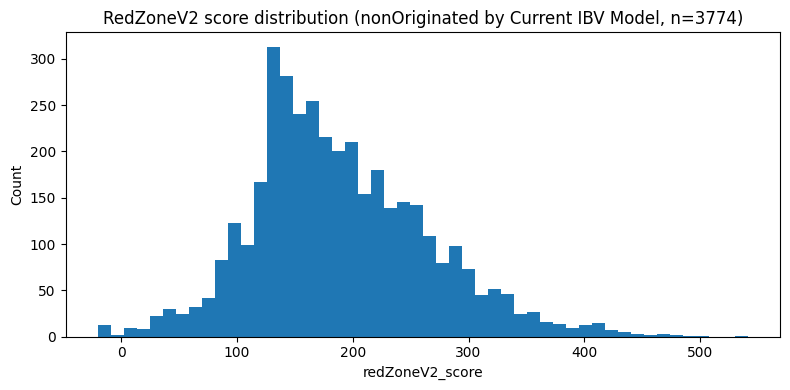

In [19]:
import matplotlib.pyplot as plt

no_perf_scores = df_perf_merged.loc[both_null, "redZoneV2_score"].dropna()

plt.figure(figsize=(8,4))
plt.hist(no_perf_scores, bins=50)
plt.title(f"RedZoneV2 score distribution (nonOriginated by Current IBV Model, n={len(no_perf_scores)})")
plt.xlabel("redZoneV2_score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()